# Inferring R_t values from pyEpiabm using an SEIR model

In this notebook we use prevalence and incidence rates from pyEpiabm to infer the $\beta$, $\gamma$ and $\kappa$ values of the
SEIR model using `seirmo`. We then use $\beta$, $\gamma$ and $\kappa$  to calculate $R_t$ and then compare it to the true underlying
values.

## Plotting output data from the Gibraltar simulation

This notebook takes data from the gibraltar_example of pyEpiabm.

This simulation was run over 90 days with a total population of 33078 and initial infected number of 100.

### SIR Plot for Gibraltar

![SIR Plot](gibraltar_outputs/simulation_flow_SIR_plot.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Underlying prevalence for Gibraltar simulation')

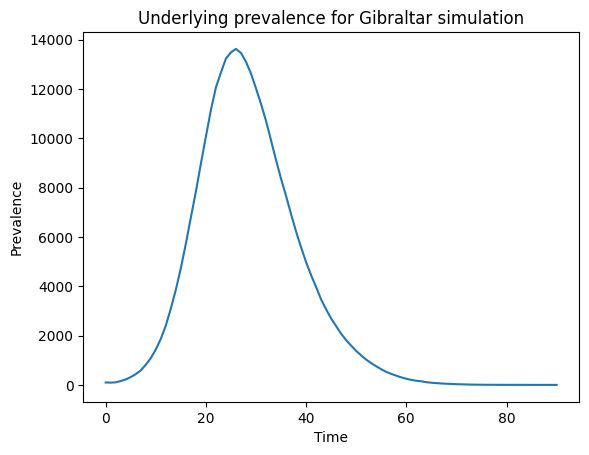

In [2]:
seir_data = pd.read_csv("gibraltar_outputs/inf_status_history.csv")
times = seir_data["time"]
# Get the true result from seir_data
susceptible_list = []
exposed_list = []
infected_list = []
recovered_list = []
for t in range(91):
    num = seir_data.iloc[t, 1:].value_counts().get(3, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(4, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(5, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(6, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(7, 0)
    num += seir_data.iloc[t, 1:].value_counts().get(8, 0)
    susceptible_list.append(seir_data.iloc[t, 1:].value_counts().get(1, 0))
    exposed_list.append(seir_data.iloc[t, 1:].value_counts().get(2, 0))
    infected_list.append(num)
    recovered_list.append(seir_data.iloc[t, 1:].value_counts().get(9, 0) + seir_data.iloc[t, 1:].value_counts().get(10, 0))
susceptible = np.array(susceptible_list)
exposed = np.array(exposed_list)
infected = np.array(infected_list)
recovered = np.array(recovered_list)
plt.plot(times, infected)
plt.xlabel("Time")
plt.ylabel("Prevalence")
plt.title("Underlying prevalence for Gibraltar simulation")

### Create $R_t$ plot

Simulations in pyEpiabm produce true $R_t$ values for each time step in a file named `secondary_infections.csv`. 

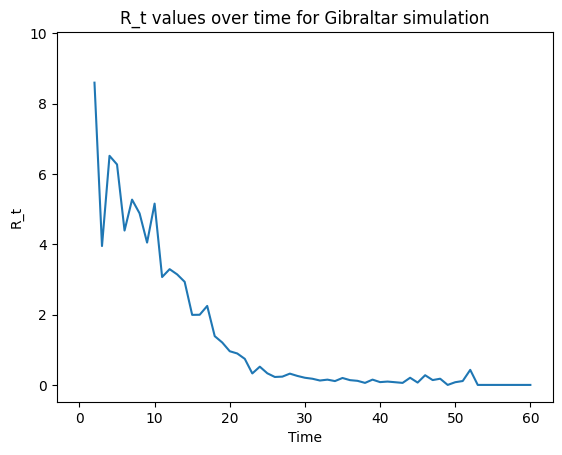

<Figure size 640x480 with 0 Axes>

In [3]:
secondary_infections_data = pd.read_csv("gibraltar_outputs/secondary_infections.csv")
plt.plot(secondary_infections_data["time"], secondary_infections_data["R_t"])
plt.xlabel("Time")
plt.ylabel("R_t")
plt.title("R_t values over time for Gibraltar simulation")
plt.show()
plt.savefig("gibraltar_outputs/simulation_flow_R_t.png")

### Create secondary infections histogram

This file also contains data for the secondary infections of each person.

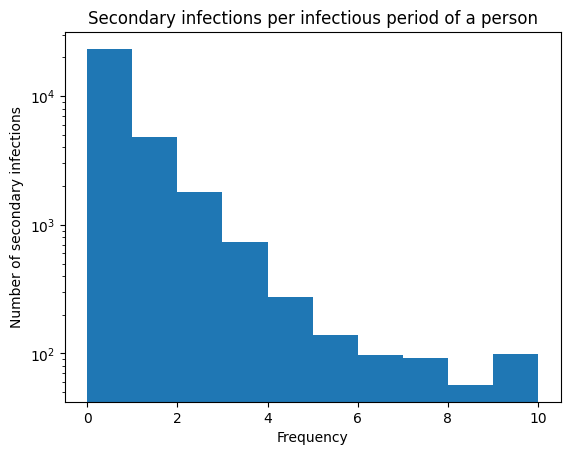

<Figure size 640x480 with 0 Axes>

In [35]:
secondary_infections_data.dropna()
secondary_infections_only = secondary_infections_data.iloc[:, 2:-1].to_numpy()
secondary_infections_array = secondary_infections_only.flatten()
plt.hist(secondary_infections_array, range=(0, 10), log=True)
plt.xlabel("Frequency")
plt.ylabel("Number of secondary infections")
plt.title("Secondary infections per infectious period of a person")
plt.show()
plt.savefig("gibraltar_outputs/simulation_flow_secondary_infections.png")

## Model Inference

### Set up

First, we normalise the data. Here is a description of our parameters:
* $S(0)$, $E(0)$, $I(0)$, $R(0)$ - Initial $S$, $E$, $I$ and $R$ values
* $\beta$, $\kappa$, $\gamma$ - Infection Rate, Incubation Rate and Recovery Rate respectively
* $\sigma_{S}$, $\sigma_{E}$, $\sigma_{I}$, $\sigma_{R}$ - The 4 hyperparameters controlling each respective log prior

In [5]:
all_data = np.array([susceptible, exposed, infected, recovered]).transpose()
pop_size = 33078
all_data = all_data / pop_size

### PINTS ForwardModel

Next, we create the forward model used to perform inference. We will be using a `ReducedModel` from `seirmo` to fix/specify specific parameters
to reduce the dimensions of the parameter space. These values are described in the table below.

|Parameter|Value|Reasoning|
|---|---|-------|
|$S(0)$|$1 - I(0)$|The total of all compartments must add up to $1$ for all time (after scaling out by `pop_size`).|
|$E(0)$|$0$|We can safely assume that no-one has been exposed at the start of the simulation.|
|$R(0)$|$0$|We also enforce that no-one has recovered at the start of the simulation.|

In [6]:
import seirmo
import pints

class SEIRModel(pints.ForwardModel):
    def __init__(self):
        super(SEIRModel, self).__init__()

        seir_model = seirmo.SEIRModel()
        self._model = seirmo.ReducedModel(seir_model)
        fixed_parameters = {"E0": 0, "R0": 0}
        self._model.fix_parameters(fixed_parameters)

    def n_outputs(self):
        # Returns number of model outputs.
        # Returns the S, E, I and R values at each timestep
        return 4

    def n_parameters(self):
        # Returns number of parameters, i.e. 1 initial condition and 3 parameters.
        return 4

    def n_fixed_parameters(self):
        # Returns number of fixed parameters, i.e. 3 initial conditions (S(0), E(0) and R(0))
        return 3

    def simulate(self, parameters, times):
        # This ensures that we are taking the prevalence
        self._model.set_outputs(["S", "E", "I", "R"])
        # S(0) is fixed to be 1 - I(0) with scaling taken into account
        parameters = np.insert(parameters, 0, 1 - parameters[0])
        compartmental_results = self._model.simulate(parameters=parameters, times=times)

        return compartmental_results

### PINTS `MultiOutputProblem` and `GaussianLogLikelihood`

We choose a Gaussian log-likelihood and an array of Gaussian log-priors for each of the different parameters of the model

In [31]:
# Create log-likelihood
pints_model = SEIRModel()
problem = pints.MultiOutputProblem(pints_model, times, all_data)
log_likelihood = pints.GaussianLogLikelihood(problem)

C:\Users\matth\AppData\Local\Temp\ipykernel_14980\2285518819.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._model.fix_parameters(fixed_parameters)


In [32]:
# Create log-prior and log-posterior
log_prior = pints.ComposedLogPrior(
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

### Initialising multiple starting locations for the chain

In [33]:
num_chains = 4
xs = log_prior.sample(num_chains)

### Performing inference

In [34]:
n_params = log_prior.n_parameters()
transform = pints.RectangularBoundariesTransformation([0] * n_params, [10] * n_params)
mcmc = pints.MCMCController(log_posterior, num_chains, xs, method=pints.PopulationMCMC, transformation=transform)
for sampler in mcmc.samplers():
    sampler.set_temperature_schedule(20)
max_iterations = 50000
mcmc.set_max_iterations(max_iterations)

chains = mcmc.run()

Using Population MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval.  i     j     Ex. i     j     Ex. i     j     Ex. i     j     Ex. Time m:s
0     4      0     1     no  0     1     no  0     1     no  0     1     no    0:00.1
1     8      2     5     no  13    16    no  0     10    yes 10    18    no    0:00.1
2     12     2     19    no  8     16    yes 7     8     yes 19    17    yes   0:00.1
3     16     2     8     no  1     6     no  16    14    yes 19    4     no    0:00.2
20    84     13    2     no  14    3     yes 10    13    no  19    17    yes   0:01.0
40    164    15    13    yes 1     2     yes 3     13    no  12    4     no    0:01.7
60    244    7     16    no  12    14    yes 16    4     no  4     10    no    0:02.3
80    324    13    9     no  16    5     no  1     8     no  11    13    no    0:03.2
100   404    5     9     no  11    8     no  15    10    no  16    7     no    0:03.8
120   484    16    8     no  7     8     no  16    19    no  16    2 

### Saving chains

In [36]:
param_names = ['I(0)', 'Infection Rate (beta)', 'Incubation Rate (kappa)', 'Recovery Rate (gamma)',
               'sigma_S', 'sigma_E', 'sigma_I', 'sigma_R']

In [37]:
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=param_names)
    df.to_csv(f"chain_data/population_mcmc/chain_{i}.csv")

## Plots

### Recovering chains from .csv files

In [38]:
list_of_chains = []
for i in range(4):
    df = pd.read_csv(f"chain_data/population_mcmc/chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

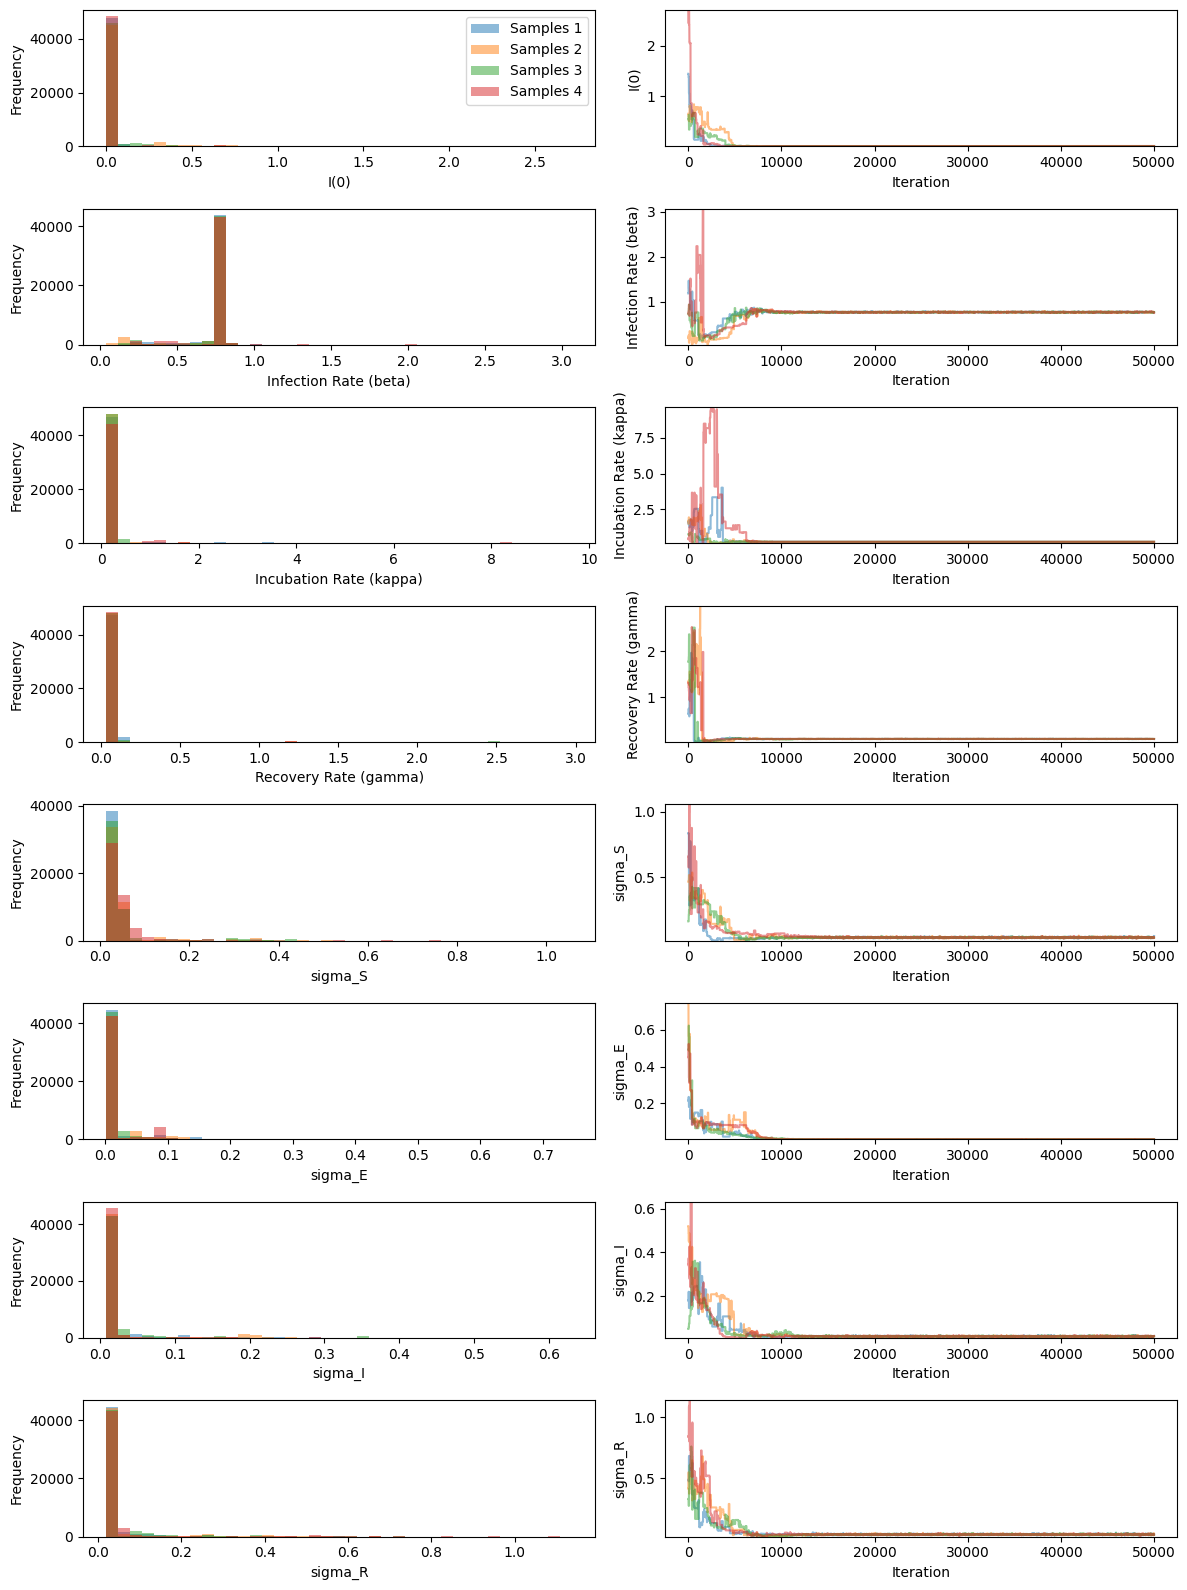

In [39]:
import pints.plot
pints.plot.trace(chains, parameter_names=param_names)
plt.show()

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [40]:
r_hat_values = pints.rhat(chains, warm_up=0.5)
for i in range(len(param_names)):
    print(f"R_hat value for {param_names[i]}: {r_hat_values[i]}")

R_hat value for I(0): 1.0042394734964517
R_hat value for Infection Rate (beta): 1.0038791809563534
R_hat value for Incubation Rate (kappa): 1.0017509890508278
R_hat value for Recovery Rate (gamma): 1.0040779932825776
R_hat value for sigma_S: 1.0040462413122142
R_hat value for sigma_E: 1.0024711595979403
R_hat value for sigma_I: 1.00262733936622
R_hat value for sigma_R: 1.0040042687067985


We will now discount the first half of the iterations.

In [42]:
chains = chains[:, int(max_iterations / 2):]

### Predicted time series plots

#### Chain 1

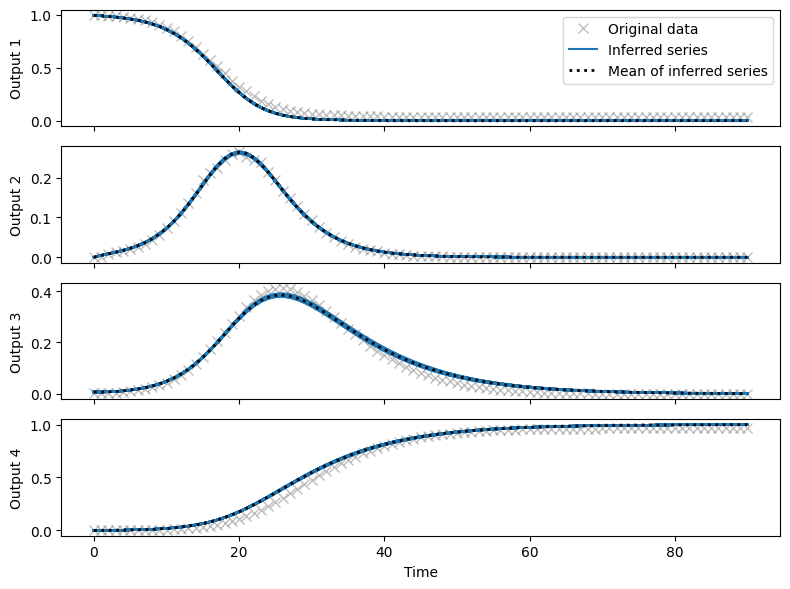

In [43]:
pints.plot.series(chains[0, :], problem)
plt.show()

#### Chain 2

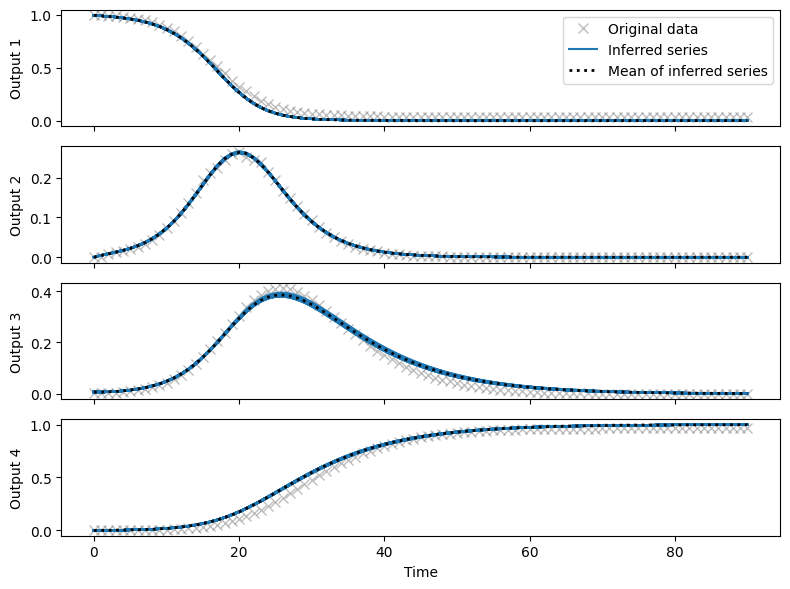

In [44]:
pints.plot.series(chains[1, :], problem)
plt.show()

#### Chain 3

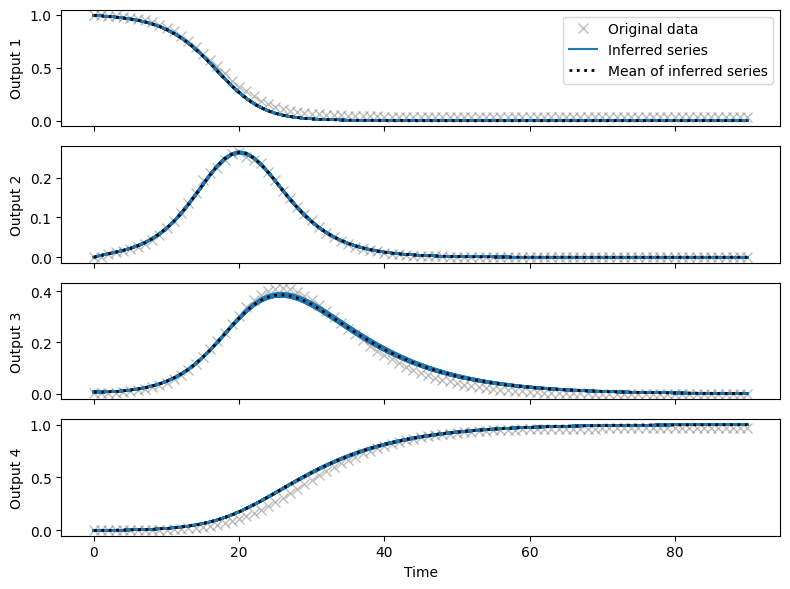

In [45]:
pints.plot.series(chains[2, :], problem)
plt.show()

#### Chain 4

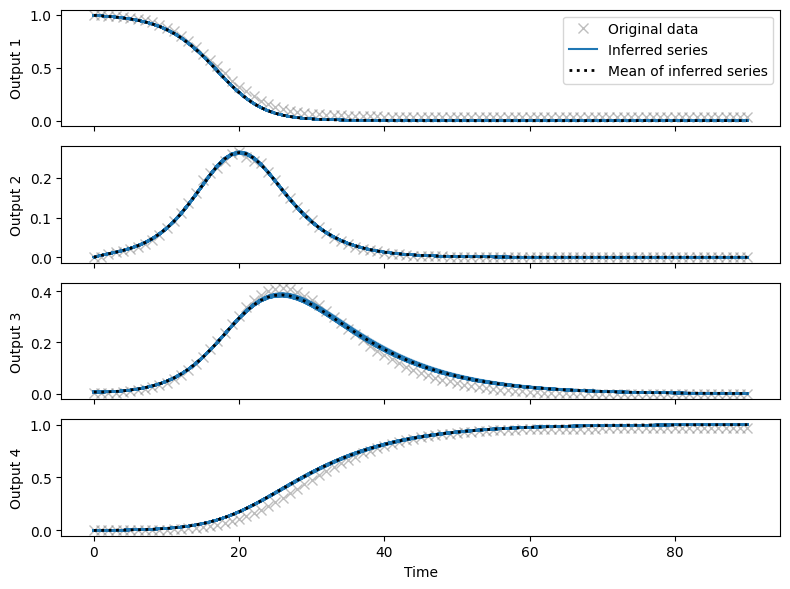

In [46]:
pints.plot.series(chains[3, :], problem)
plt.show()

## Estimating $R_t$

Now we will move on to estimating the value of $R_t$. The effective reproduction number, $R_t$, is defined as:

$$R_{t} = \frac{\beta}{\gamma N}S(t),$$

where $\beta$ and $\gamma$ are as defined previously, $N$ is the total population and $S(t)$ is the number of susceptible people at time $t$.

### Rescaling and extracting $\beta$ and $\gamma$

In [47]:
chains_df = pd.DataFrame(columns=param_names + ['chain'])
for i in range(4):
    chain_i_df = pd.DataFrame(chains[i], columns=param_names)
    for population_parameter in ["I(0)", "sigma_S", "sigma_E", "sigma_I", "sigma_R"]:
        chain_i_df[population_parameter] = pop_size * chain_i_df[population_parameter]
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_14980\371855814.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


In [48]:
beta_posterior = chains_df["Infection Rate (beta)"].to_numpy()
gamma_posterior = chains_df["Recovery Rate (gamma)"].to_numpy()
print(beta_posterior)
print(gamma_posterior)

[0.75995835 0.75995835 0.75995835 ... 0.74830017 0.74830017 0.74830017]
[0.10185869 0.10185869 0.10185869 ... 0.10132106 0.10132106 0.10132106]


In [49]:
import random

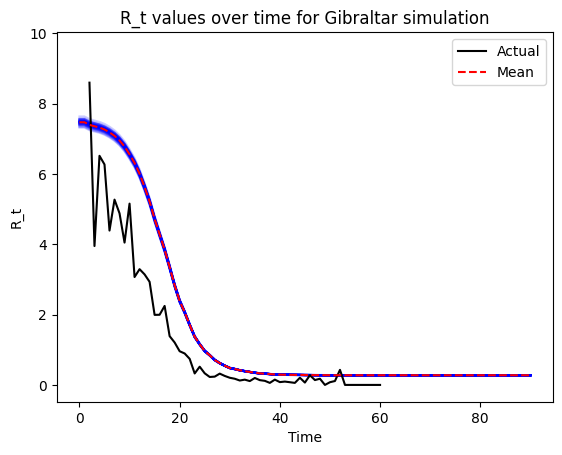

<Figure size 640x480 with 0 Axes>

In [50]:
R_t_list = []
num_samples = 100
for j in range(num_samples):
    k = random.randint(0, len(beta_posterior))
    R_t_list.append(beta_posterior[k] / (gamma_posterior[k] * pop_size) * susceptible)
    plt.plot(secondary_infections_data["time"], R_t_list[j], 'b', alpha=0.1)
mean_R_t = np.mean(np.array(R_t_list), axis=0)
std_dev_R_t = np.std(np.array(R_t_list), axis=0)
plt.plot(secondary_infections_data["time"], secondary_infections_data["R_t"], 'k', label="Actual")
plt.plot(secondary_infections_data["time"], mean_R_t, '--r', label="Mean")
plt.xlabel("Time")
plt.ylabel("R_t")
plt.title("R_t values over time for Gibraltar simulation")
plt.legend()
plt.show()
plt.savefig("inference_outputs/inferred_R_t.png")